In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score


In [10]:
# Load your dataset
file_path = r"C:\Users\safad\Desktop\advertising_dataset new.xlsx"
df = pd.read_excel(file_path)
print(df.head())
print(df.info())


   Ad_ID  Platform   Ad_Type  Budget_USD  Duration_Days Target_Age_Group  \
0      1   YouTube     Video     9982.16             19            45-54   
1      2  LinkedIn     Video      134.70             25            45-54   
2      3    Google  Carousel      373.53             29              55+   
3      4  LinkedIn     Story     8256.02             19            25-34   
4      5  LinkedIn    Banner     2074.68             18            45-54   

  Target_Gender   CTR  Conversion_Rate  Ad_Spend_USD  Ad_Success  
0           All  4.55             0.01        409.93           1  
1          Male  5.89             0.39        156.14           1  
2          Male  3.87             0.15       2659.86           0  
3        Female  4.71             0.44       3111.19           1  
4           All  3.64             0.10       1573.12           1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null C

In [11]:
# Check for missing values
print(df.isnull().sum())

# Check class balance
print(df['Ad_Success'].value_counts())


Ad_ID               0
Platform            0
Ad_Type             0
Budget_USD          0
Duration_Days       0
Target_Age_Group    0
Target_Gender       0
CTR                 0
Conversion_Rate     0
Ad_Spend_USD        0
Ad_Success          0
dtype: int64
Ad_Success
1    5018
0    4982
Name: count, dtype: int64


In [12]:
categorical_cols = ['Platform', 'Ad_Type', 'Target_Age_Group', 'Target_Gender']


In [13]:
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print(df_encoded.head())


   Ad_ID  Budget_USD  Duration_Days   CTR  Conversion_Rate  Ad_Spend_USD  \
0      1     9982.16             19  4.55             0.01        409.93   
1      2      134.70             25  5.89             0.39        156.14   
2      3      373.53             29  3.87             0.15       2659.86   
3      4     8256.02             19  4.71             0.44       3111.19   
4      5     2074.68             18  3.64             0.10       1573.12   

   Ad_Success  Platform_Google  Platform_Instagram  Platform_LinkedIn  \
0           1            False               False              False   
1           1            False               False               True   
2           0             True               False              False   
3           1            False               False               True   
4           1            False               False               True   

   Platform_YouTube  Ad_Type_Carousel  Ad_Type_Story  Ad_Type_Video  \
0              True             F

In [14]:
num_cols = ['Budget_USD', 'Duration_Days', 'CTR', 'Conversion_Rate', 'Ad_Spend_USD']
scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])


In [15]:
X = df_encoded.drop(['Ad_Success', 'Ad_ID'], axis=1)
y = df_encoded['Ad_Success']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape, X_test.shape)


(8000, 18) (2000, 18)


In [16]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.61      0.62      0.61       996
           1       0.62      0.61      0.61      1004

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.61      0.61      0.61      2000



In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))


Random Forest:
               precision    recall  f1-score   support

           0       0.60      0.64      0.62       996
           1       0.62      0.58      0.60      1004

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.61      0.61      0.61      2000



In [18]:
# !pip install xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost:\n", classification_report(y_test, y_pred_xgb))


XGBoost:
               precision    recall  f1-score   support

           0       0.57      0.59      0.58       996
           1       0.58      0.57      0.57      1004

    accuracy                           0.58      2000
   macro avg       0.58      0.58      0.58      2000
weighted avg       0.58      0.58      0.58      2000



C:\Users\safad\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:52:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


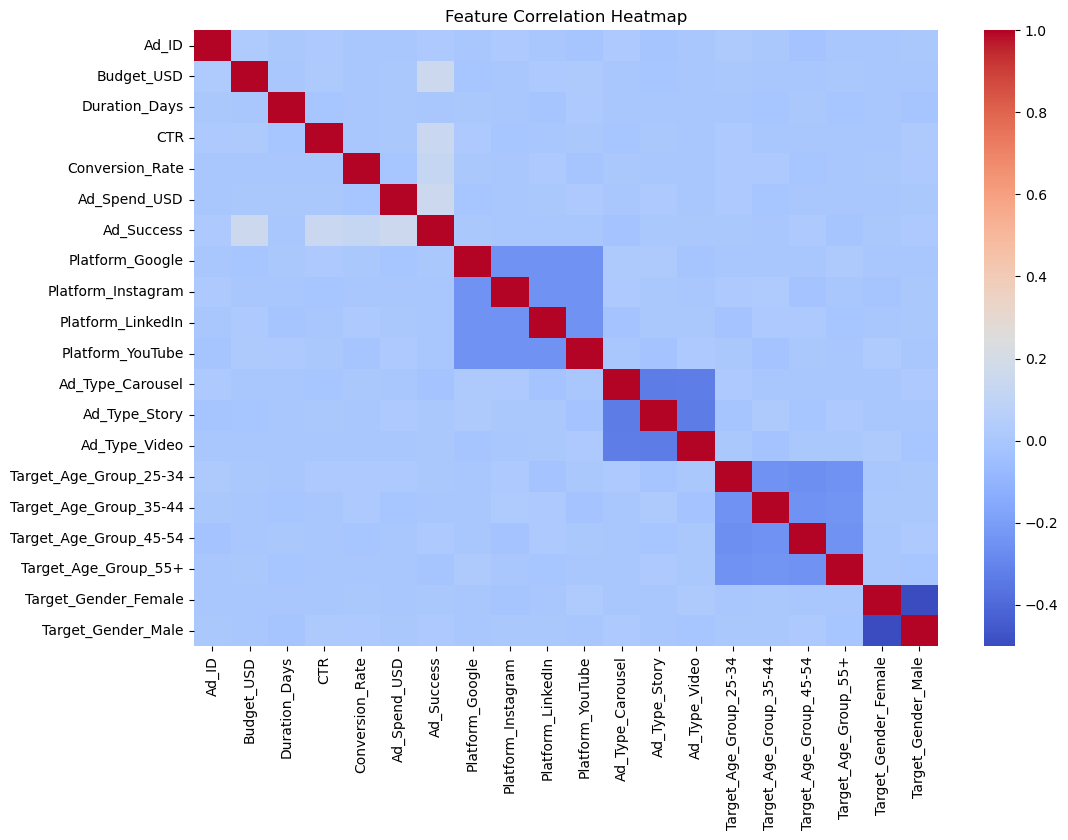

In [19]:
plt.figure(figsize=(12,8))
sns.heatmap(df_encoded.corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


In [23]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

grid = GridSearchCV(XGBClassifier(eval_metric='logloss', random_state=42), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Best F1 score:", grid.best_score_)

# Evaluate the best model
best_xgb = grid.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)
print("Tuned XGBoost:\n", classification_report(y_test, y_pred_best_xgb))


Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best F1 score: 0.6234124779702986
Tuned XGBoost:
               precision    recall  f1-score   support

           0       0.61      0.60      0.61       996
           1       0.61      0.62      0.62      1004

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.61      0.61      0.61      2000



In [24]:
scores = cross_val_score(best_xgb, X, y, cv=5, scoring='f1')
print("Cross-validated F1 scores:", scores)
print("Mean F1:", scores.mean())


Cross-validated F1 scores: [0.58337689 0.63452266 0.6263684  0.61122449 0.60652591]
Mean F1: 0.6124036707918263


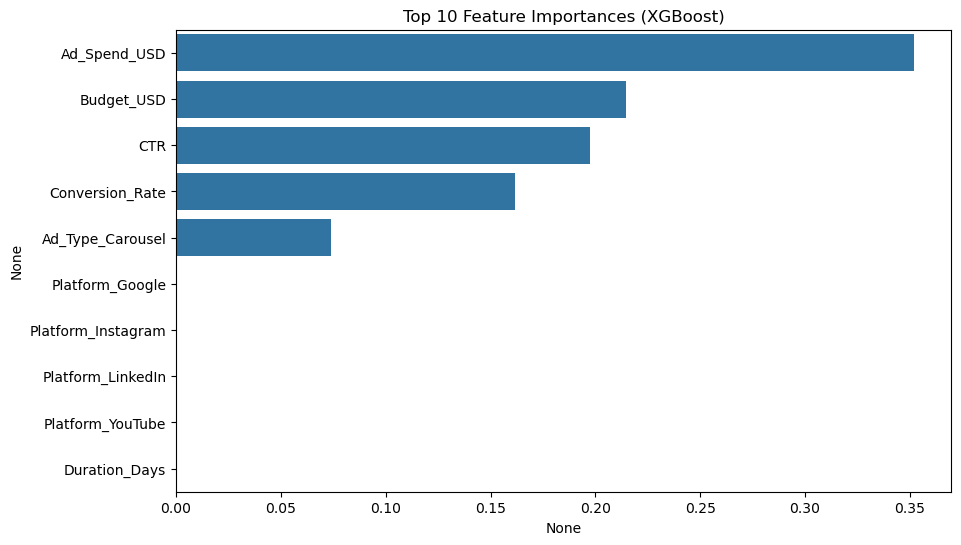

In [25]:
importances = best_xgb.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()


In [26]:
results = []
models = {
    'Logistic Regression': (lr, y_pred_lr),
    'Random Forest': (rf, y_pred_rf),
    'XGBoost': (xgb, y_pred_xgb),
    'Tuned XGBoost': (best_xgb, y_pred_best_xgb)
}

for name, (model, y_pred) in models.items():
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
    })

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy  Precision    Recall        F1   ROC-AUC
0  Logistic Regression    0.6140   0.616232  0.612550  0.614386  0.654340
1        Random Forest    0.6065   0.615058  0.577689  0.595788  0.634736
2              XGBoost    0.5785   0.582395  0.566733  0.574457  0.604895
3        Tuned XGBoost    0.6130   0.612305  0.624502  0.618343  0.641432


In [27]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.61      0.62      0.61       996
           1       0.62      0.61      0.61      1004

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.61      0.61      0.61      2000



In [28]:
from sklearn.svm import SVC
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)


In [29]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)


In [30]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)


In [31]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)


In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = {
    "SVM": (svm, y_pred_svm),
    "KNN": (knn, y_pred_knn),
    "Naive Bayes": (nb, y_pred_nb),
    "MLP (Neural Net)": (mlp, y_pred_mlp)
}

results = []
for name, (model, y_pred) in models.items():
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else "N/A"
    })

results_df = pd.DataFrame(results)
print(results_df)


              Model  Accuracy  Precision    Recall        F1   ROC-AUC
0               SVM    0.6150   0.621118  0.597610  0.609137  0.642652
1               KNN    0.5560   0.557654  0.558765  0.558209  0.567134
2       Naive Bayes    0.6075   0.609829  0.605578  0.607696  0.648749
3  MLP (Neural Net)    0.5530   0.559653  0.513944  0.535826  0.574977


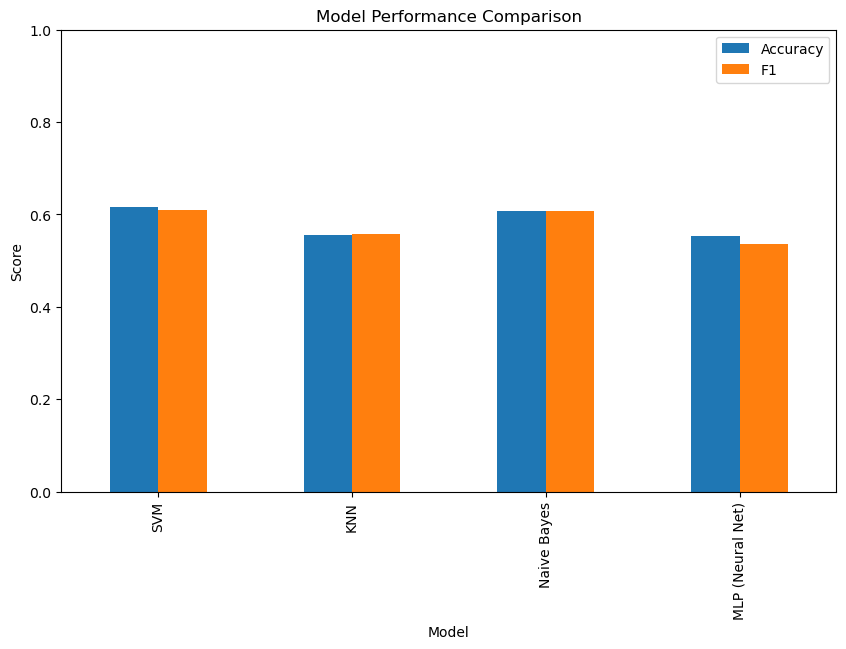

In [33]:
import matplotlib.pyplot as plt

results_df.set_index('Model')[['Accuracy', 'F1']].plot(kind='bar', figsize=(10,6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0,1)
plt.show()


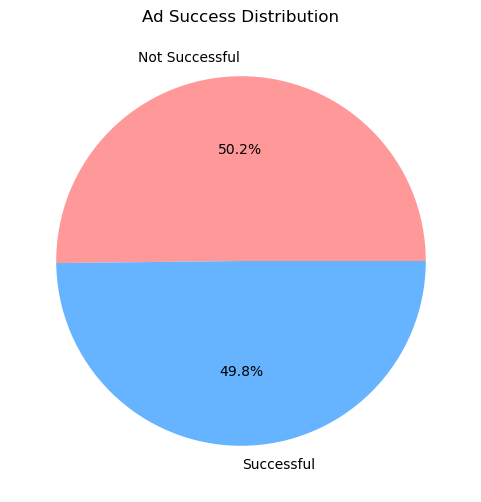

In [34]:
plt.figure(figsize=(6,6))
df['Ad_Success'].value_counts().plot.pie(
    autopct='%1.1f%%', labels=['Not Successful', 'Successful'], colors=['#ff9999','#66b3ff']
)
plt.title('Ad Success Distribution')
plt.ylabel('')
plt.show()


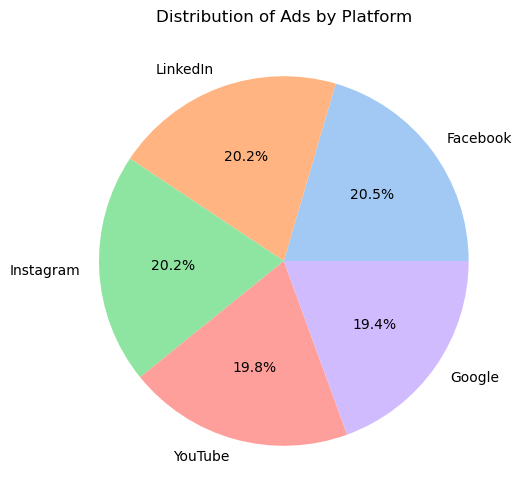

In [35]:
plt.figure(figsize=(6,6))
df['Platform'].value_counts().plot.pie(
    autopct='%1.1f%%', colors=sns.color_palette('pastel')[0:len(df['Platform'].unique())]
)
plt.title('Distribution of Ads by Platform')
plt.ylabel('')
plt.show()


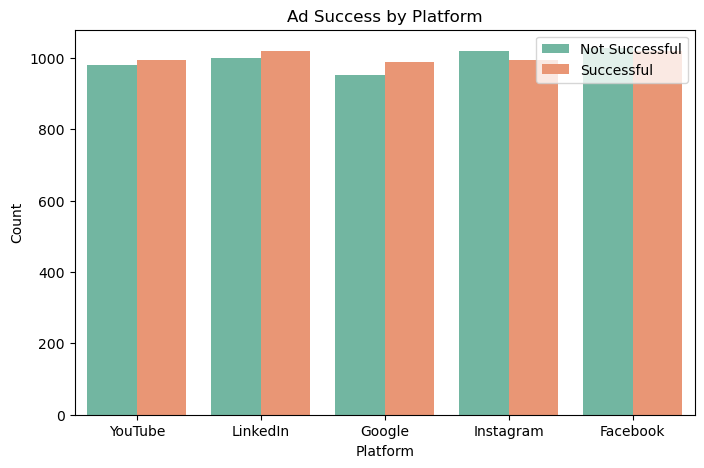

In [36]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Platform', hue='Ad_Success', palette='Set2')
plt.title('Ad Success by Platform')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.legend(['Not Successful', 'Successful'])
plt.show()


C:\Users\safad\AppData\Local\Temp\ipykernel_2448\2080821901.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Ad_Type', palette='Set3')


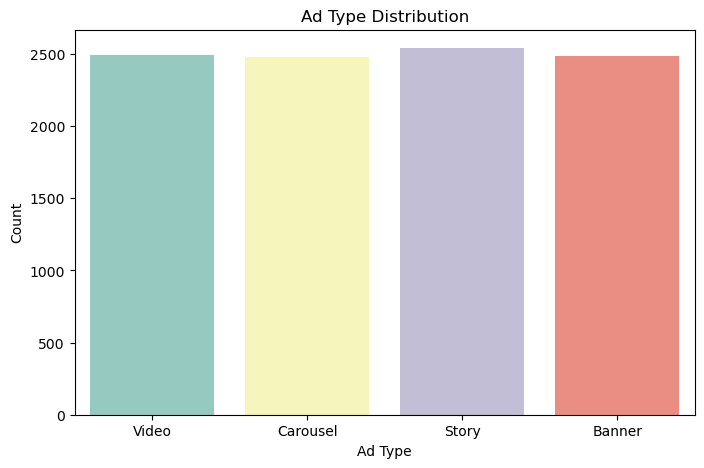

In [37]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Ad_Type', palette='Set3')
plt.title('Ad Type Distribution')
plt.xlabel('Ad Type')
plt.ylabel('Count')
plt.show()


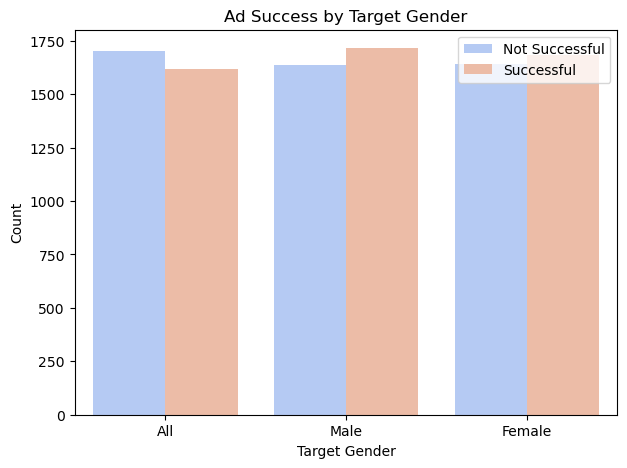

In [38]:
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='Target_Gender', hue='Ad_Success', palette='coolwarm')
plt.title('Ad Success by Target Gender')
plt.xlabel('Target Gender')
plt.ylabel('Count')
plt.legend(['Not Successful', 'Successful'])
plt.show()


C:\Users\safad\AppData\Local\Temp\ipykernel_2448\3107825168.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Ad_Success', y='CTR', data=df, palette='Set1')


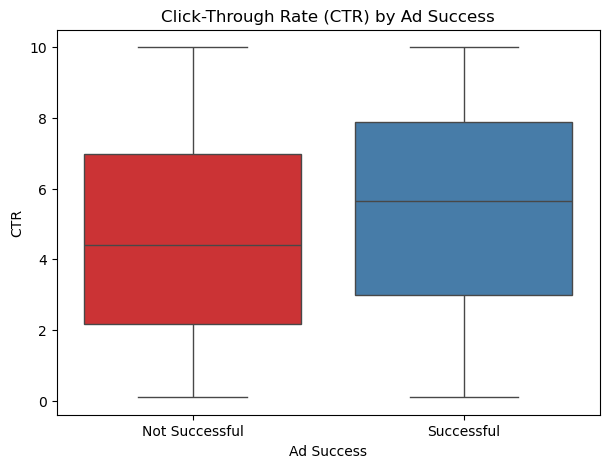

In [39]:
plt.figure(figsize=(7,5))
sns.boxplot(x='Ad_Success', y='CTR', data=df, palette='Set1')
plt.title('Click-Through Rate (CTR) by Ad Success')
plt.xlabel('Ad Success')
plt.ylabel('CTR')
plt.xticks([0,1], ['Not Successful', 'Successful'])
plt.show()


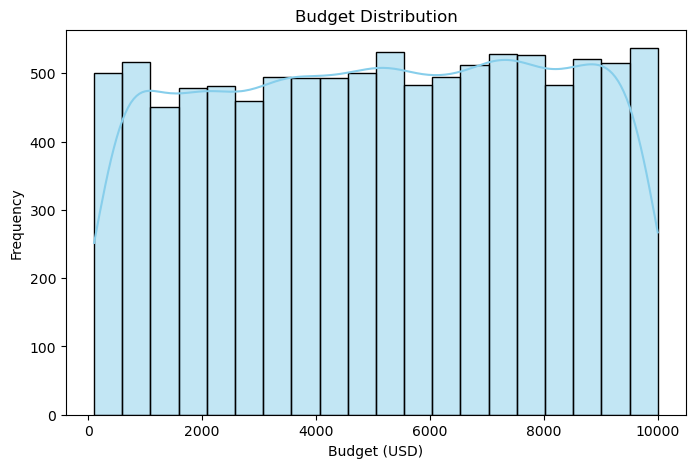

In [40]:
plt.figure(figsize=(8,5))
sns.histplot(df['Budget_USD'], bins=20, kde=True, color='skyblue')
plt.title('Budget Distribution')
plt.xlabel('Budget (USD)')
plt.ylabel('Frequency')
plt.show()


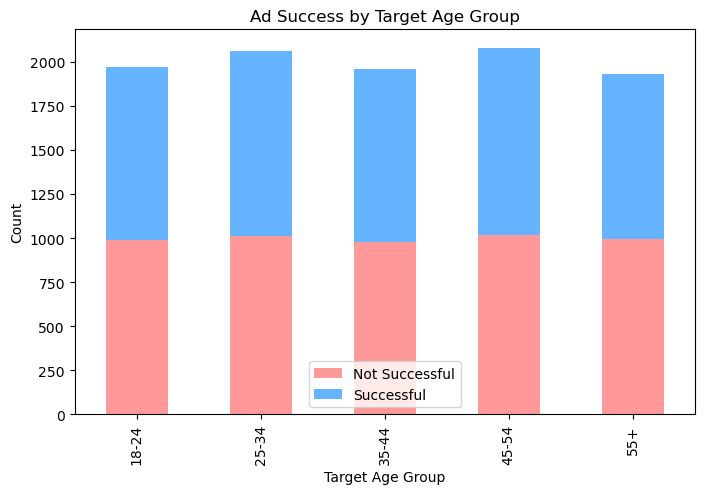

In [41]:
age_success = pd.crosstab(df['Target_Age_Group'], df['Ad_Success'])
age_success.plot(kind='bar', stacked=True, color=['#ff9999','#66b3ff'], figsize=(8,5))
plt.title('Ad Success by Target Age Group')
plt.xlabel('Target Age Group')
plt.ylabel('Count')
plt.legend(['Not Successful', 'Successful'])
plt.show()


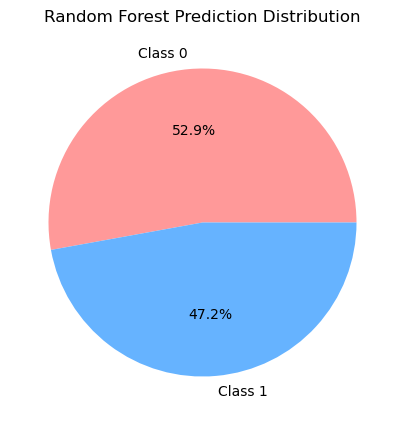

In [42]:
import numpy as np

# Example for Random Forest predictions
unique, counts = np.unique(y_pred_rf, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(counts, labels=[f'Class {u}' for u in unique], autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title('Random Forest Prediction Distribution')
plt.show()


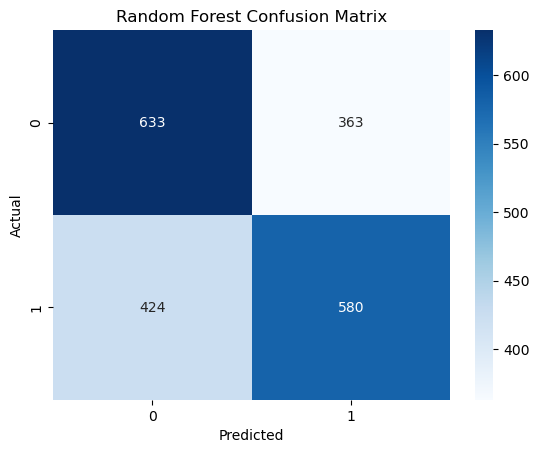

In [43]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


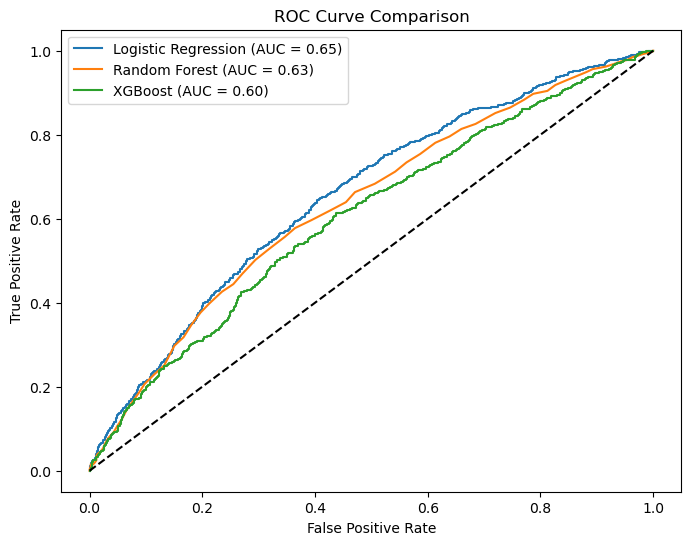

In [44]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))
for name, model in [('Logistic Regression', lr), ('Random Forest', rf), ('XGBoost', xgb)]:
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


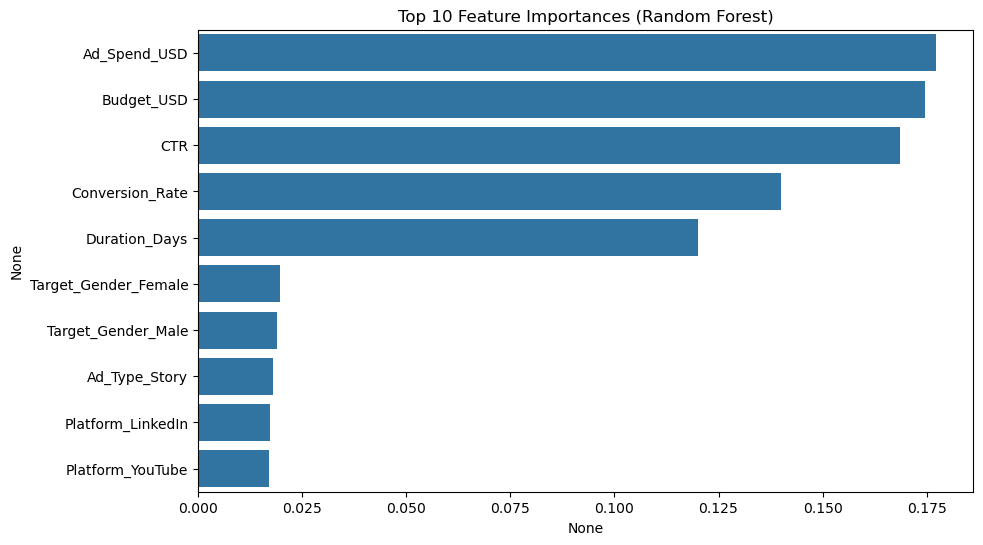

In [45]:
importances = rf.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()


In [46]:
from IPython.display import display
display(results_df)


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,SVM,0.6150,0.621118,0.597610,0.609137,0.642652
1,KNN,0.5560,0.557654,0.558765,0.558209,0.567134
2,Naive Bayes,0.6075,0.609829,0.605578,0.607696,0.648749
3,MLP (Neural Net),0.5530,0.559653,0.513944,0.535826,0.574977


In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = {
    "Logistic Regression": (lr, y_pred_lr),
    "Random Forest": (rf, y_pred_rf),
    "XGBoost": (xgb, y_pred_xgb),
    "SVM": (svm, y_pred_svm),
    "KNN": (knn, y_pred_knn),
    "Naive Bayes": (nb, y_pred_nb),
    "MLP (Neural Net)": (mlp, y_pred_mlp)
}

results = []
for name, (model, y_pred) in models.items():
    # Some models may not have predict_proba (e.g., SVM with probability=False)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        roc_auc = "N/A"
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc
    })

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy  Precision    Recall        F1   ROC-AUC
0  Logistic Regression    0.6140   0.616232  0.612550  0.614386  0.654340
1        Random Forest    0.6065   0.615058  0.577689  0.595788  0.634736
2              XGBoost    0.5785   0.582395  0.566733  0.574457  0.604895
3                  SVM    0.6150   0.621118  0.597610  0.609137  0.642652
4                  KNN    0.5560   0.557654  0.558765  0.558209  0.567134
5          Naive Bayes    0.6075   0.609829  0.605578  0.607696  0.648749
6     MLP (Neural Net)    0.5530   0.559653  0.513944  0.535826  0.574977


In [48]:
from IPython.display import display
display(results_df)


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Logistic Regression,0.6140,0.616232,0.612550,0.614386,0.654340
1,Random Forest,0.6065,0.615058,0.577689,0.595788,0.634736
2,XGBoost,0.5785,0.582395,0.566733,0.574457,0.604895
3,SVM,0.6150,0.621118,0.597610,0.609137,0.642652
4,KNN,0.5560,0.557654,0.558765,0.558209,0.567134
5,Naive Bayes,0.6075,0.609829,0.605578,0.607696,0.648749
6,MLP (Neural Net),0.5530,0.559653,0.513944,0.535826,0.574977


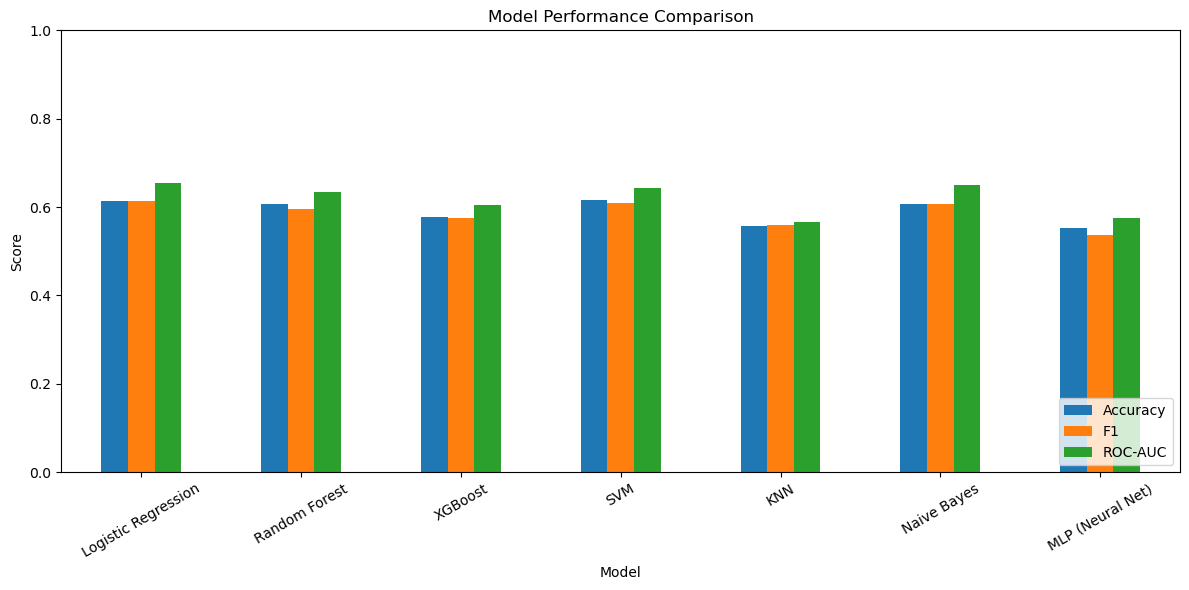

In [49]:
import matplotlib.pyplot as plt

# Only plot numeric columns
plot_df = results_df.set_index('Model')[['Accuracy', 'F1', 'ROC-AUC']]
plot_df = plot_df.apply(pd.to_numeric, errors='coerce')  # Convert ROC-AUC to numeric if needed

plot_df.plot(kind='bar', figsize=(12,6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0,1)
plt.xticks(rotation=30)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [50]:
# Display with pandas styling
styled_df = results_df.style.set_properties(**{
    'background-color': '#f0f8ff',   # Light blue background
    'color': 'black',                # Text color
    'border-color': 'gray'           # Border color
}).set_caption("Model Performance Summary Table") \
  .set_table_styles([{
      'selector': 'caption',
      'props': [('color', 'navy'), ('font-size', '18px'), ('font-weight', 'bold')]
  }])

display(styled_df)


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Logistic Regression,0.614000,0.616232,0.612550,0.614386,0.654340
1,Random Forest,0.606500,0.615058,0.577689,0.595788,0.634736
2,XGBoost,0.578500,0.582395,0.566733,0.574457,0.604895
3,SVM,0.615000,0.621118,0.597610,0.609137,0.642652
4,KNN,0.556000,0.557654,0.558765,0.558209,0.567134
5,Naive Bayes,0.607500,0.609829,0.605578,0.607696,0.648749
6,MLP (Neural Net),0.553000,0.559653,0.513944,0.535826,0.574977
